Project Objective:

1-Data Collection & Cleaning


2-Exploratory Data Analysis (EDA)


3-Feature Engineering


4-Modeling 


5-Key Insights

In [1]:
from glob import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [2]:
!pip install category_encoders
from category_encoders import OneHotEncoder

In [3]:
df = pd.read_csv('mexico-city-real-estate-1.csv')
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


In [4]:
#building a function to wrangle through data 
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    #filtering data
    mask_df = df['place_with_parent_names'].str.contains('Distrio Federal')
    mask_apt =df['property_type'] == 'apartment'
    mask_prices = df['price_aprox_usd'] <100000
    df = df[mask_df & mask_apt & mask_prices]
    
    #removing outliers for 'surface_covered_in_m2'
    low,high = df['surface_covered_in_m2'].quantile([0.1,0.9])
    mask_area = df['surface_covered_in_m2'].between(low,high)
    df = df[mask_area]
    
    #df[['lat','lon']] = df['lat-lon'].str.split(',', expand=True).astype(float)
    #df.drop(columns='lat-lon', inplace=True)
    
    df = df[df['lat-lon'].str.contains(',', na=False)].copy()
    
    # Step 2: Split into 'lat' and 'lon'
    lat_lon = df['lat-lon'].str.split(',', expand=True)
    df['lat'] = lat_lon[0].astype(float)  # First part → lat
    df['lon'] = lat_lon[1].astype(float)  # Second part → lon
    df.drop(columns='lat-lon', inplace=True)
    
    df['borough'] = df['place_with_parent_names'].str.split('|',expand=True)[1]
    df.drop(columns='place_with_parent_name', inplace=True)
    
    #dropping columns with 50% or more null values
    df.drop(columns=['surface_total_in_m2','price_usd_per_m2','floor','rooms','expenses'],inplace=True)
    
    #dropping columns with gih cardinality categorical values
    df.drop(columns=['properati_url','currency','operations','property_tyoe'],inplace=True)
    
    #dropping columns that would constitute leakage for the target 'price_aprox_usd'
    df.drop(columns['price_aprox_local_currency','price_per_m2','price'],inplace=True)
    
    #dropping Nan rows
    df = df.dropna()
    
    return df 

In [5]:
#testing wrangle function and exploring data
df = wrangle('mexico-city-real-estate-1.csv')

print(df.info())
df.head()

KeyError: 0

In [7]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Filtering
    mask_df = df['place_with_parent_names'].str.contains('Distrito Federal', na=False)
    mask_apt = df['property_type'] == 'apartment'
    mask_prices = df['price_aprox_usd'] < 100000
    df = df[mask_df & mask_apt & mask_prices].copy()
    
    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = df['surface_covered_in_m2'].between(low, high)
    df = df[mask_area].copy()

    # Step 1: Convert 'lat-lon' to string and drop NaN
    df['lat-lon'] = df['lat-lon'].astype(str)  # Ensure all values are strings
    df = df[df['lat-lon'] != 'nan'].copy()     # Drop NaN (now strings like 'nan')
    
    # Step 2: Split only rows with a comma
    df = df[df['lat-lon'].str.contains(',', na=False)].copy()
    
    # Step 3: Split into lat/lon
    lat_lon_split = df['lat-lon'].str.split(',', expand=True)
    df['lat'] = lat_lon_split[0].str.strip().astype(float)  
    df['lon'] = lat_lon_split[1].str.strip().astype(float)
    df.drop(columns='lat-lon', inplace=True)

    
    # Extract borough
    df['borough'] = df['place_with_parent_names'].str.split('|', expand=True)[1]
    df.drop(columns='place_with_parent_names', inplace=True)
    
    # Drop unnecessary columns
    cols_to_drop = [
        'surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses',
        'properati_url', 'currency', 'operation', 'property_type',
        'price_aprox_local_currency', 'price_per_m2', 'price'
    ]
    df.drop(columns=cols_to_drop, inplace=True)
    
    return df.dropna()

In [8]:
df = wrangle('mexico-city-real-estate-1.csv')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1041 non-null   float64
 1   surface_covered_in_m2  1041 non-null   float64
 2   lat                    1041 non-null   float64
 3   lon                    1041 non-null   float64
 4   borough                1041 non-null   object 
dtypes: float64(4), object(1)
memory usage: 48.8+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [9]:
#creating list of all mexico real_estate data
files = glob('mexico-city-real-estate-*.csv')
files

['mexico-city-real-estate-1.csv',
 'mexico-city-real-estate-2.csv',
 'mexico-city-real-estate-3.csv',
 'mexico-city-real-estate-4.csv',
 'mexico-city-real-estate-5.csv']

In [11]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)
    
df = pd.concat(frames, ignore_index = True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5149 entries, 0 to 5148
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5149 non-null   float64
 1   surface_covered_in_m2  5149 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5149 non-null   object 
dtypes: float64(4), object(1)
memory usage: 201.3+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


Exploring data using histogram showing the distribution of apartment prices('price_aprox_usd') in df

Text(0.5, 1.0, 'Distribution of Apartment Prices')

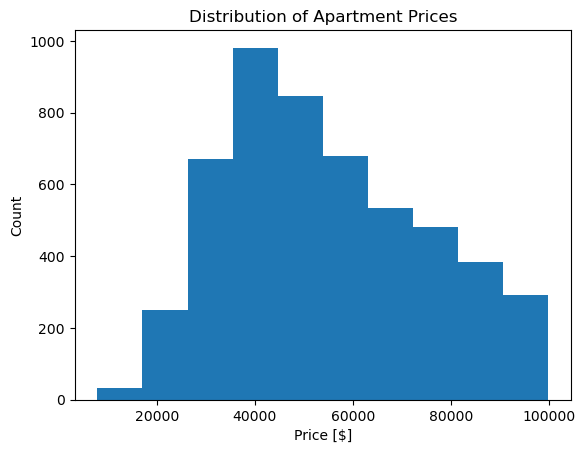

In [14]:
#building histogram
plt.hist(df['price_aprox_usd'])
#label axes
plt.xlabel('Price [$]')
plt.ylabel('Count')
#Add title
plt.title('Distribution of Apartment Prices')


Creating a Scatter plot that shows apartment price ('price_aprox_usd') as a function of apartment size ("surface_covered_in_m2")

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

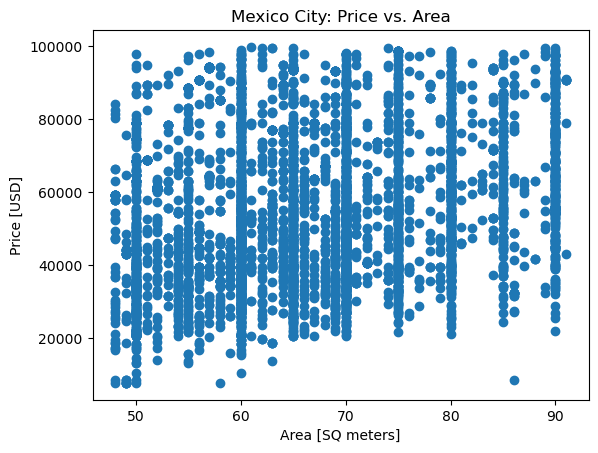

In [15]:
#building a scatter plot
plt.scatter(x=df['surface_covered_in_m2'], y= df['price_aprox_usd'])

plt.xlabel('Area [SQ meters]')
plt.ylabel('Price [USD]')
plt.title('Mexico City: Price vs. Area')

Creating a scatter Mapbox scatter plot that shows the location of the apartments in the dataset representing prices in colors 

In [20]:
import plotly.express as px 

fig = px.scatter_mapbox(
    df,
    lat='lat',
    lon='lon',
    width=600,
    height=600,
    color='price_aprox_usd',
    hover_data=['price_aprox_usd'],
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=10,  # Add zoom level
    mapbox_center={"lat": df['lat'].mean(), "lon": df['lon'].mean()} 
)
fig.show()

Creating feature matrix X_train and target Vector y_train, the target shall be 'price_aprox_usd', the features shall be all the columns that remain in the cleaned DataFrame

In [21]:
features = ['surface_covered_in_m2','lat','lon','borough']
X_train = df[features]

y_train = df['price_aprox_usd'] 

Building A model:
    1-Calculating Baseline mean_absolute_error for the model
    2-Iterating
    3-Evaluating 

In [23]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print('Mean Apt Price:', y_mean)
print('Baseline MAE:', baseline_mae)

Mean Apt Price: 54527.09548067587
Baseline MAE: 17136.33436556927


##
Creating a pipeline Named model that contains all the transformation necessary for this dataset, then training the data 


In [24]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(df)
df_ohe = ohe.transform(df)
print(df_ohe.info())
df_ohe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5149 entries, 0 to 5148
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_aprox_usd                 5149 non-null   float64
 1   surface_covered_in_m2           5149 non-null   float64
 2   lat                             5149 non-null   float64
 3   lon                             5149 non-null   float64
 4   borough_Benito Juárez           5149 non-null   int64  
 5   borough_Iztacalco               5149 non-null   int64  
 6   borough_Azcapotzalco            5149 non-null   int64  
 7   borough_Coyoacán                5149 non-null   int64  
 8   borough_Álvaro Obregón          5149 non-null   int64  
 9   borough_Iztapalapa              5149 non-null   int64  
 10  borough_Cuauhtémoc              5149 non-null   int64  
 11  borough_Tláhuac                 5149 non-null   int64  
 12  borough_Miguel Hidalgo          51

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough_Benito Juárez,borough_Iztacalco,borough_Azcapotzalco,borough_Coyoacán,borough_Álvaro Obregón,borough_Iztapalapa,borough_Cuauhtémoc,borough_Tláhuac,borough_Miguel Hidalgo,borough_Venustiano Carranza,borough_Tlalpan,borough_Gustavo A. Madero,borough_Xochimilco,borough_La Magdalena Contreras,borough_Cuajimalpa de Morelos
0,94022.66,57.0,23.634501,-102.552788,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,70880.12,56.0,19.402413,-99.095391,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,68228.99,80.0,19.357820,-99.149406,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,24235.78,60.0,19.504985,-99.208557,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,94140.20,50.0,19.354219,-99.126244,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [25]:
#building the model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
#fitting The model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

Evaluation:
Reading the CSV file into the DataFrame X_test

In [26]:
X_test = pd.read_csv("mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


Using the model to generate a Series of predictions for X_test.

In [27]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53203.447306
1    53526.276558
2    35495.868774
3    53152.507781
4    68682.844177
dtype: float64

Communicating Results:

Creating a Series named feat_imp to contain the names of all the features that the model consider when making predictions 

In [30]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp 

borough_Tláhuac                  -13561.173197
borough_Iztapalapa               -12115.920390
borough_Gustavo A. Madero         -7225.537023
borough_La Magdalena Contreras    -6498.969588
borough_Venustiano Carranza       -5824.269654
lon                               -2390.425726
borough_Cuauhtémoc                 -265.888972
surface_covered_in_m2               292.828893
borough_Iztacalco                   354.678778
lat                                 623.318395
borough_Miguel Hidalgo             1289.157763
borough_Azcapotzalco               2114.914101
borough_Álvaro Obregón             3472.904964
borough_Xochimilco                 3841.319255
borough_Coyoacán                   4111.144472
borough_Cuajimalpa de Morelos      6961.135237
borough_Tlalpan                    9642.366970
borough_Benito Juárez             13704.137282
dtype: float64

In [31]:
#exploring the length of coefficients and features series
print(len(coefficients))
print(len(features))
print(features)

18
18
['surface_covered_in_m2' 'lat' 'lon' 'borough_Benito Juárez'
 'borough_Iztacalco' 'borough_Azcapotzalco' 'borough_Coyoacán'
 'borough_Álvaro Obregón' 'borough_Iztapalapa' 'borough_Cuauhtémoc'
 'borough_Tláhuac' 'borough_Miguel Hidalgo' 'borough_Venustiano Carranza'
 'borough_Tlalpan' 'borough_Gustavo A. Madero' 'borough_Xochimilco'
 'borough_La Magdalena Contreras' 'borough_Cuajimalpa de Morelos']


Text(0.5, 1.0, 'Feature Importance for Apartment Price')

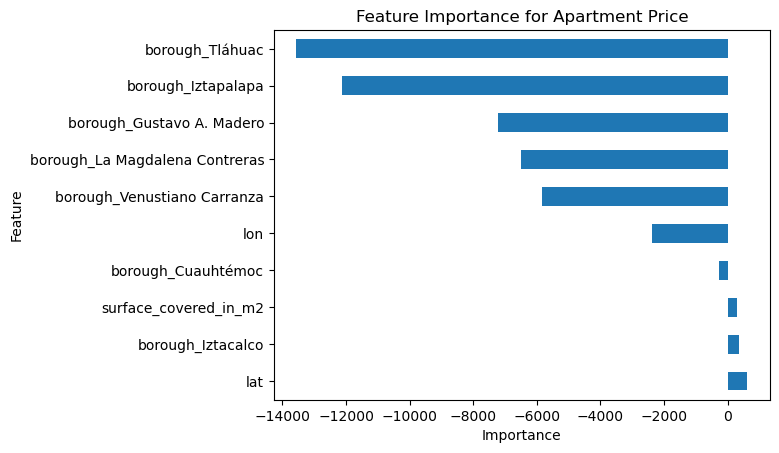

In [32]:
#showing the most 10 influential coefficients for the model 
feat_imp.sort_values(ascending=False).tail(10).plot(kind='barh')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Apartment Price')

Text(0.5, 1.0, 'Feature Importance for Apartment Price')

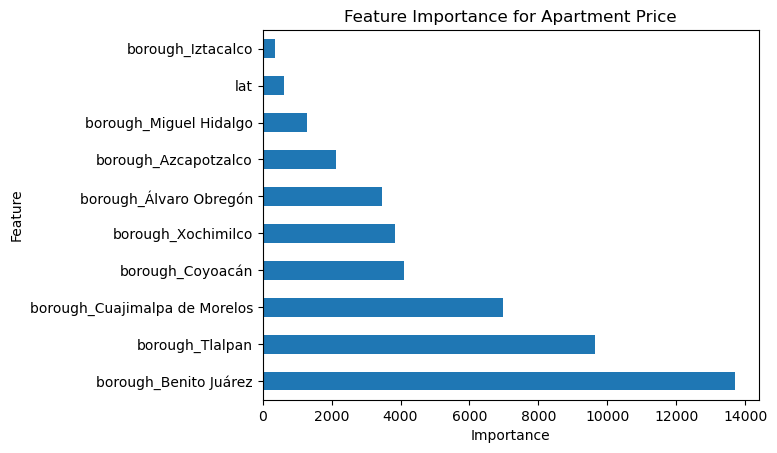

In [33]:
feat_imp.sort_values(ascending=False).head(10).plot(kind='barh')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Apartment Price')

Key insights from the Feature Importance for Apartment Price graph:

1-Top Influential Features
surface_covered_in_m2 (property size) has the highest positive impact on apartment prices as expected, larger apartments generally cost more.

2-Borough-Specific Trends
borough_Cuauhtémoc is a desirable area with a strong positive effect on prices.

borough_Tiáhuac, borough_Iztapalapa, and borough_Gustavo A. Madero show negative importance, suggesting apartments there are cheaper.

3-Latitude (lat)
Positive importance indicates prices increase as you move north.